In [37]:
import sys, os

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.util import im2col
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt


In [29]:
# 引数（データ個数、1データのチャンネル数、1データの高さ、1データの幅）
x1 = np.random.rand(1, 3, 7, 7)
# im2colはフィルタの適用範囲ごとに、1行のデータに変換しそれを縦に並べた形にする。
# 1行ごとにフィルタの適用処理が簡単にできる。
# im2col(入力データ、フィルターの高さ、フィルターの横幅、ストライド、パディング)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)


(9, 75)
(90, 75)


In [30]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        # フィルターの個数、チャンネル数、フィルター高さ、フィルター幅
        FN, C, FH, FW = self.W.shape
        # 入力データの個数、チャンネル数、高さ、幅
        N, C, H, W = x.shpae
        # 出力サイズ高さ
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        # 出力サイズ幅
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        # 入力データをim2colで展開
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターも展開
        # reshapeで-1を指定すると、自動で要素数の辻褄が合うようにまとめてくれる
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        # 出力を元のサイズに戻す。
        # transposeは多次元配列の軸の順番を入れ替える。
        # transpose(0,3,1,2)は、元の多次元配列の軸(0,1,2,3)を(0,3,1,2)に入れ替える事を示す。
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out


In [31]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展開（1）
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 最大値（2）
        out = np.max(col, axis=1)
        # 整形（3）
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out


In [32]:
class SimpleConvNet:
    def __init_(
        self,
        input_dim=(1, 28, 28),
        conv_param={"filter_num": 30, "filter_size": 5, "pad": 0, "stride": 1},
        hidden_size=100,
        output_size=10,
        weight_init_std=0.01,
    ):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (
            input_size - filter_size + 2 * filter_pad
        ) / filter_stride + 1
        pool_outpu_size = int(
            filter_num * (conv_output_size / 2) * (conv_output_size / 2)
        )

        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(
            filter_num, input_dim[0], filter_size, filter_size
        )
        self.params["b1"] = np.zeros(filter_num)
        self.params["W2"] = weight_init_std * np.random.randn(
            pool_outpu_size, hidden_size
        )
        self.params["b2"] = np.zeros(hidden_size)
        self.params["W3"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b3"] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(
            self.params["W1"],
            self.params["b1"],
            conv_param["stride"],
            conv_param["pad"],
        )
        self.layers["Relu1"] = layers.Relu()
        self.layers["Pool1"] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Relu2"] = layers.Relu()
        self.layers["Affine2"] = layers.Affine(self.params["W3"], self.params["b3"])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads["W1"] = self.layers["Conv1"].dW
        grads["b1"] = self.layers["Conv1"].db
        grads["W2"] = self.layers["Affine1"].dW
        grads["b2"] = self.layers["Affine1"].db
        grads["W3"] = self.layers["Affine2"].dW
        grads["b3"] = self.layers["Affine2"].db

        return grads


In [39]:
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer


In [40]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20
network = SimpleConvNet(
    input_dim=(1, 28, 28),
    conv_param={"filter_num": 30, "filter_size": 5, "pad": 0, "stride": 1},
    hidden_size=100,
    output_size=10,
    weight_init_std=0.01,
)

trainer = Trainer(
    network,
    x_train,
    t_train,
    x_test,
    t_test,
    epochs=max_epochs,
    mini_batch_size=100,
    optimizer="Adam",
    optimizer_param={"lr": 0.001},
    evaluate_sample_num_per_epoch=1000,
)

trainer.train()

# パラメータ保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')


train loss:2.3000011078979186
=== epoch:1, train acc:0.119, test acc:0.12 ===
train loss:2.298152643089111
train loss:2.2955666554498517
train loss:2.2881633252232088
train loss:2.280245211772289
train loss:2.2695880770127657
train loss:2.259504076409803
train loss:2.249433952857369
train loss:2.2368578529409926
train loss:2.205682737759244
train loss:2.1574144944706983
train loss:2.1409400870836777
train loss:2.0849170795983905
train loss:2.075237386279413
train loss:2.016049986883303
train loss:1.9487132771178681
train loss:1.8528623599211445
train loss:1.8545486605518406
train loss:1.8113750878614807
train loss:1.7447347334696863
train loss:1.7291916359626012
train loss:1.5365602856274585
train loss:1.4715239001823872
train loss:1.3974739390866155
train loss:1.3088157936839402
train loss:1.2617177103139112
train loss:1.0337879514472637
train loss:1.0217196230079653
train loss:1.0296731387861464
train loss:0.9483515772656267
train loss:0.9340655252789403
train loss:0.908569036316296


KeyboardInterrupt: 

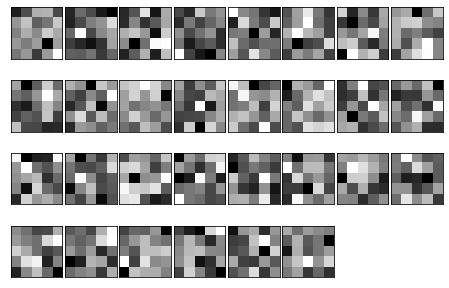

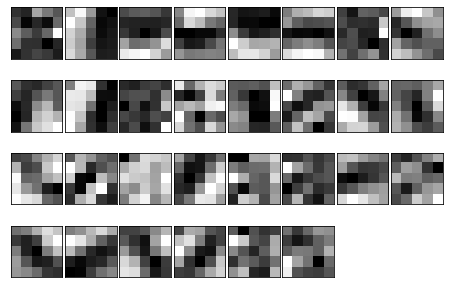

In [42]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("ch07/params.pkl")
filter_show(network.params['W1'])